### CNN을 통한 이미지 품질 분류
- Good, Error 로 구성되는 이진 분류임
- 라벨링 어떻게 되는가 => 이미지 전처리 class : __getitem__ !!
    - pytorch 예전에 내가 했던거랑 비교해서 공부

In [5]:
#import PIL.Image as pilimg
from PIL import Image
import cv2
import matplotlib.pyplot as plt

from google.colab.patches import cv2_imshow
from google.colab import drive

import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### image => ndarray & imshow

In [6]:
import os
# train 데이터에서 good, error 별로 경로 정의
good_path = "/content/drive/MyDrive/gear/gear/train/good"
error_path = "/content/drive/MyDrive/gear/gear/train/error"

good_image_list = os.listdir(good_path)
error_image_list = os.listdir(error_path)

print(good_image_list)
print(error_image_list)

['NonDefect-5.bmp', 'NonDefect-8.bmp', 'NonDefect-9.bmp', 'NonDefect-4.bmp', 'NonDefect-1.bmp', 'NonDefect-2.bmp', 'NonDefect-3.bmp', 'NonDefect-0.bmp']
['Defect-18.bmp', 'Defect-15.bmp', 'Defect-16.bmp', 'Defect-14.bmp', 'Defect-13.bmp', 'Defect-12.bmp', 'Defect-10.bmp', 'Defect-11.bmp', 'Defect-1.bmp', 'Defect-0.bmp', 'Defect-17.bmp', 'Defect-19.bmp', 'Defect-56.bmp', 'Defect-55.bmp', 'Defect-54.bmp', 'Defect-53.bmp', 'Defect-51.bmp', 'Defect-50.bmp', 'Defect-52.bmp', 'Defect-5.bmp', 'Defect-49.bmp', 'Defect-27.bmp', 'Defect-3.bmp', 'Defect-4.bmp', 'Defect-25.bmp', 'Defect-26.bmp', 'Defect-23.bmp', 'Defect-24.bmp', 'Defect-22.bmp', 'Defect-21.bmp', 'Defect-20.bmp', 'Defect-2.bmp', 'Defect-8.bmp', 'Defect-7.bmp', 'Defect-6.bmp', 'Defect-9.bmp']


In [7]:
good = [] # 이미지를 ndarray로 바꾸어서 저장

for good_image_list_value in good_image_list:
  img = Image.open(good_path + '/' + good_image_list_value) 
  good.append(np.array(img))

In [8]:
error = []
 
for error_image_list_value in error_image_list:
  img = Image.open(error_path + '/' + error_image_list_value) 
  error.append(np.array(img))

In [9]:
good[0].shape # 535*535, 3 channels

(535, 535, 3)

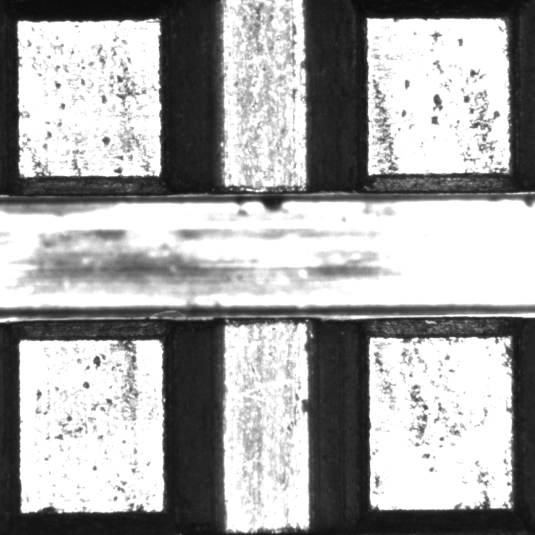

In [10]:
cv2_imshow(good[0])

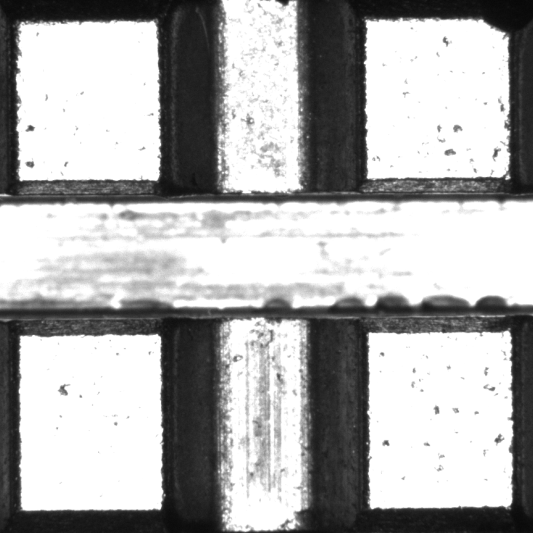

In [11]:
cv2_imshow(error[0])

In [12]:
# ★학습 데이터 전처리 모듈
# ★init, get item, len은 어느정도 정형화됨

class ImageLoader(Dataset):
    
    def read_data_set(self):
        all_img_files = []      
        all_labels = []
        class_names = os.walk(self.data_set_path).__next__()[1]
        print(class_names)

        for index, class_name in enumerate(class_names):
            
            label = index
            img_dir = os.path.join(self.data_set_path, class_name)
            img_files = os.walk(img_dir).__next__()[2]

            for img_file in img_files:
                img_file = os.path.join(img_dir, img_file)
                img = Image.open(img_file)
                
                if img is not None:
                  all_img_files.append(img_file)
                  all_labels.append(label)

        return all_img_files, all_labels, len(all_img_files), len(class_names)

    def __init__(self, data_set_path, transforms=None):
        
        self.data_set_path = data_set_path
        self.image_files_path, self.labels, self.length, self.num_classes = self.read_data_set()
        self.transforms = transforms

    def __getitem__(self, index):
        
        image = Image.open(self.image_files_path[index])
        #image = Image.convert("RGB")

        if self.transforms is not None:
          image = self.transforms(image)

        return {'image': image, 'label': self.labels[index]}

    def __len__(self):
        return self.length

In [13]:
# ★pytorch - 1_dataloader & 다른 소스코드 많이 참고 : 같은 클래스 별 폴더 이미지 데이터 사용하는경우
# 이렇게만으로 데이터도 불러오고 ★레이블도 자동으로 매겨지며, 전처리까지 됨 

# 1. 전처리 방법 설정
TransformsTrain = transforms.Compose([transforms.Resize((64, 64)),
                                        transforms.RandomRotation(10.), # 부족한 이미지 양 늘리는 기법이라는데
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.2, 0.2, 0.2])])
# 2. class 객체 선언
TrainDataSet = ImageLoader(data_set_path='/content/drive/MyDrive/gear/gear/train', # 이 경로 밑에 따라서 label 정의됨
                                                transforms=TransformsTrain)
# 3. DataLoader 통과시켜 batch 단위로 만듦
TrainLoader = DataLoader(TrainDataSet, batch_size=8, shuffle=True)


TransformsTest = transforms.Compose([transforms.Resize((64, 64)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.2, 0.2, 0.2])])
TestDataSet = ImageLoader(data_set_path='/content/drive/MyDrive/gear/gear/test', 
                                            transforms=TransformsTest)
TestLoader = DataLoader(TestDataSet, batch_size=8, shuffle=True)

['error', 'good']
['error', 'good']


In [22]:
# CNN 네트워크 구조 정의
class cnn(nn.Module):
    def __init__(self, input_dim, hid_dim, out_dim):
        super(cnn, self).__init__()
        self.input_dim = input_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        # 이렇게 같은 종류의 레이어로 쓸꺼 많을땐 하단에 함수로 정의해서 이렇게 표현가능
        ## 인자 넣는 방법 이부분 강의
        self.layer1 = self.conv_layer(input_dim, hid_dim)
        self.layer2 = self.conv_layer(hid_dim, hid_dim*2)
        self.layer3 = self.conv_layer(hid_dim*2, hid_dim*4)
        self.layer4 = self.conv_layer(hid_dim*4, hid_dim*8)
        self.layer5 = self.conv_avg_layer(hid_dim*8, out_dim)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        ## 이 부분 강의 : task가 무엇인지 위주로 생각
        out = out.view(-1, self.out_dim)
        return out

    def conv_layer(self, in_size, out_size):
        return nn.Sequential(
            nn.Conv2d(in_size, out_size, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_size),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def conv_avg_layer(self, in_size, out_size):
        return nn.Sequential(
            nn.Conv2d(in_size, out_size, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_size),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )

In [23]:
model = cnn(3,32,2).cuda() ## task가 무엇인가, 마지막 2는 무슨뜻인가

In [26]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [27]:
losses = []
for e in range(1000):

  for i_batch, item in enumerate(TrainLoader):      
    images = item['image'].cuda()
    labels = item['label'].cuda()

    outputs = model(images)        
    L = loss(outputs, labels)
    losses.append(L.item())
    # Backward and optimize
    optimizer.zero_grad()
    L.backward()
    optimizer.step()
  if (e+1)%500 == 0:
    print('[Epoch: {}/{}], [Loss: {:.4f}]'.format(e + 1, 1000, L.item()))

[Epoch: 500/1000], [Loss: 0.0498]
[Epoch: 1000/1000], [Loss: 0.0059]


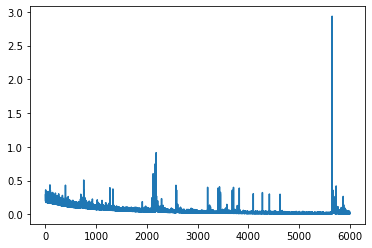

In [28]:
plt.plot(losses)

In [29]:
model.eval()  
with torch.no_grad():
    correct = 0
    total = 0
    for item in TestLoader:
      images = item['image'].cuda()
      labels = item['label'].cuda()
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += len(labels)
      correct += (predicted == labels).sum().item()

print('[Test Accuracy: {:4f}]'.format(100 * correct / total))

[Test Accuracy: 95.652174]


[과제] 자동차 기어 데이터를 이용하여 테스트 데이터의 분류 정확도를 향상시켜보시오

기존과 동일하게 과제용 데이터로 모델링을 수행한다음 과제용 데이터를 이용하여 예측을 수행할 것

네트워크 구조는 동일하게 사용해도되며, 변경해도 가능

파라미터 및 기타 학습에 필요한 다양한 FUNCTION을 변경해도됨